### Voice Recognition of Spoken dialogue for Speech to Text - [article](https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch), [notebook](https://colab.research.google.com/drive/1IPpwx4rX32rqHKpLz7dc8sOKspUa-YKO)

Convert spoken speech to text. Based on Deep Speech 2 model from Baidu.

**Todos**
*   DONE WER Metrics
*   DONE run_predict
*   DONE Diff values of n_fft, Freq masking, amplitude to db
*   DONE CTC Loss with reduction = None
*   Test Dataset


### Import KD Libraries

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# Install torchaudio library, which is part of Pytorch, for audio data
# Since Colab currently used Pytorch 1.7, we need torchaudio v0.7
!pip install torchaudio==0.7

     |████████████████████████████████| 7.6MB 5.7MB/s 


In [5]:
import IPython.core.debugger as db
from pathlib import Path
import numpy as np

import torchaudio
import torch
print(torch.__version__)
from torch import nn
import torch.nn.functional as F
from torch.utils.data import SequentialSampler, RandomSampler
from torch.nn.utils.rnn import pad_sequence

1.7.0+cu101


/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')
gd_path = 'gdrive/My Drive/Colab Data/fastai-v3'  #change dir to your project folder
gn_path = 'gdrive/My Drive/Colab Notebooks'  #change dir to your project folder

import sys
sys.path.insert(1, gn_path + '/exp')

Mounted at /content/gdrive


In [7]:
from nb_util import save_pickle, load_pickle, DebugRand
from nb_audio import AudioUtil
from nb_data import DataBundle, ItemContainer, AudioItemList
from nb_training import MetricsBaseCB
from nb_arch import ArchBase
from nb_app import AppBase

### Define data paths

In [8]:
app_dir='speech'

root_path = Path.cwd()
download_path = root_path/app_dir
data_path = download_path

pickle_dir = root_path/'pickle'

### Speech-to-text Dataset and Databundle

In [36]:
#----------------------------------------------------
# Create a vocab using just the alphabet characters and space, along with
# mapping from id->chars and chars->id. This vocab is used during model
# training for metric evaluation
#----------------------------------------------------
class CharVocab():
  def __init__(self):
    self._create_vocab()

  def _create_vocab(self):
    # vocab using the alphabet characters, single-quote and space
    all_chars = list("""' abcdefghijklmnopqrstuvwxyz""")
    self.vocab_i2c = all_chars
    self.vocab_c2i = {c:id for id, c in enumerate(all_chars)}

  def SentenceToCharId(self, sentence):
    sentence_char_ids = [self.vocab_c2i[c] for c in sentence]
    return sentence_char_ids

  def CharIdToSentence(self, sentence_char_ids):
    sentence = [self.vocab_i2c[cid] for cid in sentence_char_ids]
    sentence = ''.join(sentence)
    return sentence

global_vocab = CharVocab()

# ----------------------------
# Collate function to convert a list of item tuples into a single tensor which is fed
# as input to the model
#
# 'Samples' is a list of tuples ie. [(x1, y1), (x2, y2), ...] where 'xn' are the spectrograms
# and 'yn' are the list of character ids in the sentence. Both the spectrograms and the 
# sentence could have different lengths, so after each 'xn' and 'yn' are converted to 
# tensors, they are padded at the end to make them the same length.
# ----------------------------
def seq_collate(samples, pad_idx=0., pad_first=False):
  # Convert each sample sentence into a tensor and then create two lists of 
  # tensors ie. [tensor x1, tensor x2, ...] and [tensor y1, tensor y2, ...]
  # Reshape spectrogram from (channels, mel freq bins, time steps) to (time steps, mel freq bins), because
  # the pad_sequence() below requires seq length (ie. time steps) as the first dimension.
  tx, ty = [torch.tensor(s[0]).squeeze(0).transpose(0, 1) for s in samples], [torch.tensor(s[1]) for s in samples]

  # Use the Pytorch pad_sequence function to pad each sample tensor to the same length and then
  # concatenate them into a single tensor. 
  px, py = pad_sequence(tx, batch_first=True, padding_value=pad_idx), pad_sequence(ty, batch_first=True, padding_value=pad_idx)

  # 'lenx' and 'leny' have shape (samples) and represent the actual length, before padding, of 
  # the predicted labels and target labels respectively.
  # 'lenx' length is halved to match the length of the model's prediction, which was
  # reduced by 2 in the model's Conv layer
  lenx, leny = [t.shape[0] // 2 for t in tx], [t.shape[0] for t in ty]
  lenx, leny = torch.tensor(lenx), torch.tensor(leny)
  # So 'px' has shape (samples, max time steps, freq bins) and 'py' has shape (samples, max sequence length)
  # 'px' becomes the input to the model
  # [py, lenx, leny] are the target values which get passed to the CTC Loss. They are also
  # used by the Decoder to generate output during Inference and Metric Evaluation.
  return px, [py, lenx, leny]

#----------------------------------------------------
# Dataset containing a Speech ItemList. All of the data pre-processing is done
# here, and not in the Databundle or in the ItemList. The Dataset is created with
# both 'x' and 'y' parameters being the same Speech Item List. So we use the 'x' 
# for accessing the data and ignore the 'y'.
# 
# The Speech Item List is just a thin wrapper over the TorchAudio dataset. That
# way we can benefit from the Torchaudio capabilities by accessing it directly
# rather than by layering a full-fledged ItemList over it.
#----------------------------------------------------
class STDataset():
  def __init__(self, x, y):
    self.x, self.y = x, y
    self._create_vocab()
    # !!!!!!!!! Should be passed in from db.create_ds()
    self.in_train = True
    
  def __len__(self):
    return (len(self.x))
  
  # ----------------------------
  # Get a (x, y) pair for one sample that can be passed to the model. 
  # ----------------------------
  def __getitem__(self, i):
    # !!!!!!!!
    if (self.in_train):
      # Access the item from the 'train_dataset' saved in the Item List
      item = self.x.train_dataset[i]
    else:
      pass

    # Get the sample data from the item. The 'waveform' is the input speech audio
    # and the 'utterance' is the target text.
    waveform, sr, utterance, _, _, _ = item

    # !!!!!!!! Figure out the parameters to the spectro functions.
    # !!!!!!!! Do we need to resample at 16000 like the other project does?
    if (False):
      spec = AudioUtil.spectro_gram((waveform, sr), n_mels=128, n_fft=400)
      spec = AudioUtil.spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
    else:
      # Transformations to convert the audio waveform to Mel Spectrograms
      from torchaudio import transforms
      spec = transforms.MelSpectrogram(sample_rate=16000, n_mels=128)(waveform)
      #spec = transforms.AmplitudeToDB(top_db=80.0)(spec)

      # We randomly mask out some frequency and time portions of the spectrogram
      # as a form of data augmentation which helps the model generalise better
      spec = transforms.FrequencyMasking(freq_mask_param=30)(spec)
      spec = torchaudio.transforms.TimeMasking(time_mask_param=100)(spec)

    # Get character IDs for the target label and convert to a tensor
    sentence_char_ids = self.SentenceToCharId(utterance.lower())
    sentence_char_ids = torch.Tensor(sentence_char_ids)

    return (spec, sentence_char_ids)

  # ----------------------------
  # Create a vocab using just the alphabet characters, single-quote and space, along with
  # mapping from id->chars and chars->id. This vocab is used only during
  # pre-processing to convert the target labels into character IDs.
  # ----------------------------
  def _create_vocab(self):
    all_chars = list("""' abcdefghijklmnopqrstuvwxyz""")
    self.vocab_i2c = all_chars
    self.vocab_c2i = {c:id for id, c in enumerate(all_chars)}

  # ----------------------------
  # Convert the text sentence to a list of character IDs based on the vocab
  # ----------------------------
  def SentenceToCharId(self, sentence):
    sentence_char_ids = [self.vocab_c2i[c] for c in sentence]
    return sentence_char_ids

#----------------------------------------------------
# Container for speech-to-text data. It loads the data directly from the
# download URL rather than downloading it manually ahead of time, and then
# doing the load from a local folder. 
#----------------------------------------------------
class TorchDatasetItemContainer(ItemContainer):
  def __init__(self, train_url, test_url, data_path):
    self.train_url, self.test_url = train_url, test_url
    self.data_path = data_path
    super().__init__()

  # ----------------------------
  # Use the LibriSpeech data set, a corpus of English transcribed speech 
  # data from audiobooks
  # ----------------------------
  def load(self, target_cls):
    self.data_path.mkdir(exist_ok=True)
    # !!!!!!! Should we download before starting the Databundle?
    train_dataset = torchaudio.datasets.LIBRISPEECH(self.data_path, url=self.train_url, download=True)
    test_dataset = torchaudio.datasets.LIBRISPEECH(self.data_path, url=self.test_url, download=True)

    # Create the Item List with the list of items
    all_rows = target_cls(items=None, train_dataset=train_dataset, test_dataset=test_dataset)
    return all_rows

#----------------------------------------------------
# This Item List is mostly a wrapper. Its items are simple indexes and all its
# real data is held in the 'train_dataset' and 'test_dataset', which are not
# processed by the Item List. Those two datasets are Torchaudio datasets so
# it is better that we harness its capabilities by accessing it directly rather
# than by layering an ItemList over it.
#----------------------------------------------------
class SpeechItemList(AudioItemList):
  def __init__(self, items, train_dataset, test_dataset, **kwargs):
    # Save the train and test dataset although we don't use them for anything
    self.train_dataset = train_dataset
    self.test_dataset = test_dataset

    # Create items as indexes based on the length of the training dataset
    items = range(len(train_dataset))
    super().__init__(items, **kwargs)

    self._copy_new.append('train_dataset')

#----------------------------------------------------
# Speech to Text data preparation pipeline
# The pipeline is only a light wrapper, the real work is done in the custom STDataset
#----------------------------------------------------
class SpeechToTextDataBundle(DataBundle):
  def __init__(self, train_url, test_url, data_path, bs=10):
    print ('--------- Speech To Text DataBundle init', train_url, test_url, data_path)

    # Download the train and test data using their URLs
    # Loaded Speech Item List only has indexes as items, actual data objects come from the 'backend' downloaded data
    # No split, extraction or convert
    # The loaded Item List is passed as both 'x' and 'y' to create the custom STDataset.
    # All the real data extraction and transformations are done when items are fetched from the Dataset.

    load_params = {'source': TorchDatasetItemContainer, 'target_cls': SpeechItemList, 'train_url': train_url, 'test_url': test_url, 'data_path': data_path}
    split_params = {'split_procedure': None}
    extract_x_params = {'extract_procedure': None, 'target_cls': None}
    extract_y_params = {'extract_procedure': None, 'target_cls': None}
    convert_x_params = [
    ]
    convert_y_params = [
    ]
    xform_x_params = [
    ]
    ds_params = {'target_ds': STDataset}
    dl_params = (
        {'bs': bs, 'sampler_fn': RandomSampler, 'collate_fn': seq_collate},           # for training
        {'bs': bs, 'sampler_fn': SequentialSampler, 'collate_fn': seq_collate}        # for valid/test
    )
    self.display_params = {
        'layout_procedure': 'display_audio', 'figsize': (30, 6),
    }
    super().__init__(load_params, split_params, extract_x_params, extract_y_params, convert_x_params, convert_y_params, xform_x_params=xform_x_params, ds_params=ds_params, dl_params=dl_params)

### Word Error Rate metric

In [45]:
#----------------------------------------------------
# These functions for calculating WER and CER were taken unmodified from the referenced
# notebook and are being treated as external library functions.
#----------------------------------------------------

def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)

#----------------------------------------------------
# Levenshtein Distance
#----------------------------------------------------
def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]

#----------------------------------------------------
# 
#----------------------------------------------------
def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)

#----------------------------------------------------
# 
#----------------------------------------------------
def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in char-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Levenshtein distance and length of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)

#----------------------------------------------------
# Word Error Rate
#----------------------------------------------------
def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer

#----------------------------------------------------
# Character Error Rate
#----------------------------------------------------
def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text in char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    We can use levenshtein distance to calculate CER. Chinese input should be
    encoded to unicode. Please draw an attention that the leading and tailing
    space characters will be truncated and multiple consecutive space
    characters in a sentence will be replaced by one space character.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Character error rate.
    :rtype: float
    :raises ValueError: If the reference length is zero.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

### Build Speech to Text Architecture

In [39]:
#----------------------------------------------------
# Wrapper on the LayerNorm module which reshapes the tensor during processing
#----------------------------------------------------
class LayerNorm(nn.Module):
  def __init__(self, n_features):
    super().__init__()
    self.ln = nn.LayerNorm(n_features)

  def forward(self, x):
    # x is (samples, channels, freq bins, time steps)

    x = x.transpose(2, 3).contiguous() # (samples, channels, time steps, freq bins)
    x = self.ln(x)
    x = x.transpose(2, 3).contiguous() # (samples, channels, freq bins, time steps)
    return x

#----------------------------------------------------
# 
#----------------------------------------------------
class ConvBlock(nn.Module):
  def __init__(self, ch_in, ch_out, kernel_sz, stride, drop_p, n_features):
    super().__init__()

    # Use LayerNorm wrapper so that it reshapes the tensor during processing
    ln = LayerNorm(n_features)
    act = nn.GELU()
    drop = nn.Dropout(drop_p)

    padding = kernel_sz // 2
    conv = nn.Conv2d(ch_in, ch_out, kernel_sz, stride, padding)

    self.block = nn.Sequential (ln, act, drop, conv)

  def forward(self, x):
    x = self.block(x)
    return x

#----------------------------------------------------
# 
#----------------------------------------------------
class ResBlock(nn.Module):
  def __init__(self, ch_in, ch_out, kernel_sz, stride, drop_p, n_features):
    super().__init__()

    self.conv_block1 = ConvBlock(ch_in, ch_out, kernel_sz, stride, drop_p, n_features)
    self.conv_block2 = ConvBlock(ch_out, ch_out, kernel_sz, stride, drop_p, n_features)

  def forward(self, x):
    residual = x    # (samples, channels, freq bins, time steps)
    
    x = self.conv_block1(x)
    x = self.conv_block2(x)

    x += residual
    return x        # (samples, channels, freq bins, time steps)

#----------------------------------------------------
# 
#----------------------------------------------------
class RNNBlock(nn.Module):
  def __init__(self, inp_sz, n_h, batch_first, drop_p):
    super().__init__()

    self.ln = nn.LayerNorm(inp_sz)
    self.act = nn.GELU()
    self.gru = nn.GRU(input_size=inp_sz, hidden_size=n_h, num_layers=1, batch_first=batch_first, bidirectional=True)
    self.drop = nn.Dropout(drop_p)

  def forward(self, x):
    x = self.ln(x)
    x = self.act(x)
    x, _ = self.gru(x)
    x = self.drop(x)
    return x 

#----------------------------------------------------
# Classifier module to classify characters for the predicted text transcript
#----------------------------------------------------
class Classifier(nn.Module):
  def __init__(self, inp_sz, drop_p, n_classes):
    super().__init__()

    lin_sz = inp_sz // 2
    lin1 = nn.Linear(in_features=inp_sz, out_features=lin_sz)
    act = nn.GELU()
    drop = nn.Dropout(drop_p)
    lin2 = nn.Linear(in_features=lin_sz, out_features=n_classes)

    self.classifier = nn.Sequential (lin1, act, drop, lin2)

  def forward(self, x):
    x = self.classifier(x)
    x = F.log_softmax(x, dim=2)
    return x 

#----------------------------------------------------
# Create the Speech To Text architecture. It consists of some Conv layers to process
# the input spectrogram images from the audio, followed by some RNN layers to
# extract character sequences from the Conv feature maps. Finally we have a Classifier to
# classify characters for each time step.
#----------------------------------------------------
class SpeechToText(nn.Module):
  def __init__(self, n_res_blocks, n_rnn_blocks, n_classes, drop_p=0.1, n_features=64, rnn_features=512):
    super().__init__()

    n_ch = 32
    kernel_sz = 3
    self.conv = nn.Conv2d(in_channels=1, out_channels=n_ch, kernel_size=kernel_sz, stride=2, padding=kernel_sz//2)

    res_blocks = [ResBlock(ch_in=n_ch, ch_out=n_ch, kernel_sz=kernel_sz, stride=1, drop_p=drop_p, n_features=n_features) for _ in range(n_res_blocks)]
    self.res = nn.Sequential(*res_blocks)

    self.lin = nn.Linear(in_features=n_features*32, out_features=rnn_features)

    n_h = rnn_features
    rnn_blocks = [RNNBlock(inp_sz=(rnn_features if i==0 else rnn_features*2), n_h=n_h, batch_first=(i==0), drop_p=drop_p) for i in range(n_rnn_blocks)]
    self.rnn = nn.Sequential(*rnn_blocks)

    self.classifier = Classifier(rnn_features * 2, drop_p=drop_p, n_classes=n_classes)

  def forward(self, x):
    # Reshape spectrogram from (samples, time steps, freq bins) to (samples, channels=1, freq bins, time steps) 
    # ie. (samples, depth, height, width) as required for the CNN
    x = x.unsqueeze(1).transpose(2, 3)

    # After the Conv layer, the Channels dimension is equal to the number of CNN filters.
    # And the Freq Bins and Time Steps dimensions get reduced by 2 due to the CNN stride.
    x = self.conv(x)    # (samples, channels, freq bins, time steps)
    x = self.res(x)     # (samples, channels, freq bins, time steps)

    sizes = x.size()
    x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (samples, features = channels * freq bins, time steps)
    x = x.transpose(1, 2)                                # (samples, time steps, features)

    x = self.lin(x)                                      # (samples, time steps, lin size)
    x = self.rnn(x)                                      # (samples, time steps, rnn hidden size)
    x = self.classifier(x)                               # (samples, time steps, classes)
    x = x.transpose(0, 1)                                # (time steps, samples, classes)

    # The predicted output has shape (time steps, samples, classes) as required by CTC Loss
    return x

#----------------------------------------------------
# Create the Speech-to-Text architecture
#----------------------------------------------------
class ArchSpeechToText(ArchBase):
  # ----------------------------
  # Create the model
  # ----------------------------
  def create_model(self, n_classes):
    super().__init__()
    self.model = SpeechToText(n_res_blocks=3, n_rnn_blocks=5, n_classes=n_classes)


### Define Audio Classification application class

In [ ]:
#----------------------------------------------------
# The overall application flow is to take the LibrisSpeech dataset provided through
# Pytorch's torchaudio. We convert the audio files into Mel Spectrograms and do some
# basic pre-processing for data augmentation of those spectrograms. We use the
# target labels from the dataset.
#
# The spectrograms are input to a Deep Speech model consisting of several CNN layers
# followed by some RNN layers and finally a Classification layer. The model outputs
# character probabilities for each time step from the spectrogram. It then uses
# CTC Loss to extract the characters and compares it to the target labels.
#
# For inference, the output is decoded into predicted text. To evaluate the model,
# it uses Character Error Rate and Word Error Rate metrics by comparing the decoded
# text with the target label.
#----------------------------------------------------

In [47]:
#----------------------------------------------------
# Decode the predicted output into a text label. The 'output' consists of the softmax
# probability for each character for each time step. The Decoder uses Greedy Search and
# picks the character with the highest probability at each time step, and then collapses
# all the Blank characters.
# The 'labels' are the target labels and 'label_lengths' are their actual lengths without padding
#----------------------------------------------------
def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
  # 'output' has shape (samples, time steps, classes)
  # 'labels' has shape (samples, padded length) and
  # 'label_lengths' has shape (samples)
  # Get the highest probability characters at each time step
	arg_maxes = torch.argmax(output, dim=2)
	decodes = []
	targets = []
  # Go through each sample
	for i, args in enumerate(arg_maxes):
		decode = []
    # Get the text string for the target label
		targets.append(global_vocab.CharIdToSentence(labels[i][:label_lengths[i]].tolist()))
  
    # Go through the character at each time step of the output, and decode them
		for j, index in enumerate(args):
      # Skip if it's a Blank. Add all other characters, after collapsing any that 
      # are repeated ie. if they are the same as the previous character.
			if index != blank_label:
				if collapse_repeated and j != 0 and index == args[j -1]:
					continue
        # Add the characters after collapsing
				decode.append(index.item())
    # Get the decoded text string for the predicted output
		decodes.append(global_vocab.CharIdToSentence(decode))
  
  # Return the decoded output and the target output, as text strings
	return decodes, targets

#----------------------------------------------------
# Word Error Rate and Character Error Rate
#----------------------------------------------------
class WerMetricsCB(MetricsBaseCB):
  header = ['cer', 'wer']

  # ----------------------------
  # Initialise count to 0 at beginning of epoch
  # ----------------------------
  def _reset(self, begin_fit=False):
    # Total number of sample rows across all batches in an epoch
    self.total_sz = 0

  # ----------------------------
  # Compute CER and WER for a batch and accumulate their values. The final
  # metrics will be determined at the end of the epoch.
  # ----------------------------   
  def _calc_batch(self, ctx, is_val=True):
    is_val = True # !!!!!!!!!!!!!!
    if (is_val):
      # Number of samples in the batch
      batch_sz = ctx.yhat.size(0)
      # Add to the count of samples for the epoch
      self.total_sz += batch_sz
      # Compute average CER and WER for the batch
      avg_cer, avg_wer = self.calc_wer(ctx.yhat, ctx.yb)
      # Accumulate 'total CER and WER' for all samples
      self.value[0] += avg_cer * batch_sz
      self.value[1] += avg_wer * batch_sz

  # ----------------------------
  # Calculate CER and WER for the epoch
  # ----------------------------
  def _calc_epoch(self, ctx):
    # CER for the epoch = accumulated CER for all samples / number of samples
    self.value[0] = self.value[0] / self.total_sz
    # WER for the epoch = accumulated WER for all samples / number of samples
    self.value[1] = self.value[1] / self.total_sz

  # ----------------------------
  # Calculate WER and CER given predicted and target values
  # ----------------------------
  def calc_wer(self, yhat, yb):
    avg_wer = 0.0
    avg_cer = 0.0

    # Get the target labels and their actual lengths (without padding)
    labels, _, label_lengths = yb
    # !!!!!!!!!!!
    labels = labels.long()
    # Get the decoded predictions and target labels
    decoded_preds, decoded_targets = GreedyDecoder(yhat.transpose(0, 1), labels, label_lengths)

    # Go through predictions and target labels for each sample and compute the
    # CER and WER
    num_preds = len(decoded_preds)
    for j in range(num_preds):
      avg_cer += cer(decoded_targets[j], decoded_preds[j])
      avg_wer += wer(decoded_targets[j], decoded_preds[j])

    # Average CER and WER for the set of samples
    avg_cer = avg_cer / num_preds
    avg_wer = avg_wer / num_preds
    return (avg_cer, avg_wer)


In [33]:
#----------------------------------------------------
# Speech-to-Text Application
#----------------------------------------------------
class AppSpeechToText(AppBase):
  def __init__(self):
    # !!!!!!!!!! Make blank = 0 and change the vocab accordingly?
    # Single-quote, Space, 26 alphabets and last is the Blank character
    self.loss_fn = nn.CTCLoss(blank=28, reduction='mean')
    super().__init__(loss_type='', metrics_cbs=[WerMetricsCB()])

  # ----------------------------
  # Create the architecture
  # ----------------------------
  def create_arch(self):
    self._arch = ArchSpeechToText()
    self._arch.create_model(n_classes=self.n_classes)
    return self._arch

  #----------------------------------------------------
  # Load the data using the Audio Classification Data Bundle
  #----------------------------------------------------
  def load_data(self, train_url, test_url, data_path):
    self.db = SpeechToTextDataBundle(train_url, test_url, data_path)
    self.db.process()

    # !!!!!!!!
    # Single-quote, Space, 26 alphabets and Blank character
    self.n_classes = 29

  #----------------------------------------------------
  # Predictions with the model
  #----------------------------------------------------
  def run_predict(self):
    # !!!!!!!!!
    test_dl = self.db.train_dl
    self._arch.model.eval()
    device = list(self._arch.model.parameters())[0].device

    inps, outs, targs = [], [], []
    test_cer, test_wer = [], []

    with torch.no_grad():
      for _, (xb, yb) in enumerate(test_dl):
        xb = xb.to(device)
        yhat = self._arch.model(xb)

        labels, _, label_lengths = yb
        # !!!!!!!!!!!
        labels = labels.long()
        decoded_preds, decoded_targets = GreedyDecoder(yhat.transpose(0, 1), labels, label_lengths)
        for j in range(len(decoded_preds)):
          test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
          test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)


  def TEMP_run_predict(self):
        pred = yhat.argmax(dim=1)
        for x, y, p in zip (xb, yb, pred):
          inp = [w for w in x]
          inps.append(inp)
          out = [w for w in p]
          outs.append(out)
          targ = [w for w in y]
          targs.append(targ)
        return inps, outs, targs

### Load Data

In [15]:
st_app = AppSpeechToText()
st_app.load_data(train_url="dev-clean", test_url="test-clean", data_path=data_path)
save_pickle(st_app, pickle_dir, 'proc_data.pkl')

--------- Speech To Text DataBundle init dev-clean test-clean /content/speech



TorchDatasetItemContainer loaded 2703 items of type SpeechItemList
No Split
No extraction
No extraction
Final SpeechItemList (2703 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...] 
 SpeechItemList (2703 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]


### Explore Data

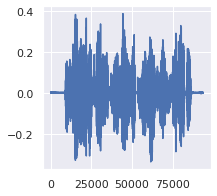

In [ ]:
test_file = download_path/'LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac'
test_aud = AudioUtil.open(test_file)
AudioUtil.play(test_aud)
AudioUtil.show_wave(test_aud)

### Train model

In [ ]:
DebugRand.set_seed(0)
st_app = load_pickle(pickle_dir/'proc_data.pkl')

st_app.create_arch()
st_app._arch.save_weights(pickle_dir/'arch_init_wgts.mdl')
st_app._arch.load_weights(pickle_dir/'arch_init_wgts.mdl')

#st_app.create_debug(use_dtr=True, track_batches_per_epoch=15, disp_tb=False, disp_pd=True, debug_bkwd=False, debug_fwd=False, abort_iter=0)

In [ ]:
find_lr = True
if (find_lr):
  loop = st_app.lr_find(start_lr=1e-7, end_lr=10, num_iter=100, weight_decay=0.1)

In [ ]:
loop = st_app.run_train(num_epochs=10, split_lr=[5e-4], weight_decay=0.1, one_cycle=True)

In [ ]:
loop = st_app.run_train(num_epochs=10, split_lr=[5e-4], weight_decay=0.01, one_cycle=True)

### Display Metrics

(None, None)

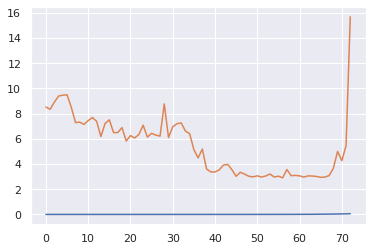

In [ ]:
recorder=loop.cbs[1]
recorder.plot_lr(), recorder.plot_loss()

In [ ]:
is_run_df, is_batch_df, is_layer_df, _ = loop.dtr.pd_results()
is_run_df
is_batch_df.head(2)
is_layer_df.head(2)

,run_id,num_epochs,row_type,epoch_id,num_tr_batches,num_val_batches,tr_loss,smooth_loss,val_loss,time
0,Run-20200902_125335,10.0,run,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Run-20200902_125335,NaN,epoch,0.0,513.0,128.0,1.783401,1.596146,1.394593,00:11
32,Run-20200902_125335,NaN,epoch,1.0,513.0,128.0,1.322697,1.252633,1.142138,00:11
63,Run-20200902_125335,NaN,epoch,2.0,513.0,128.0,1.118727,1.000213,2.886582,00:11
94,Run-20200902_125335,NaN,epoch,3.0,513.0,128.0,1.011536,1.008048,0.892014,00:11
125,Run-20200902_125335,NaN,epoch,4.0,513.0,128.0,0.912532,0.895393,0.621401,00:11
156,Run-20200902_125335,NaN,epoch,5.0,513.0,128.0,0.889057,0.897215,0.763515,00:11
187,Run-20200902_125335,NaN,epoch,6.0,513.0,128.0,0.848241,0.768907,0.606842,00:11
218,Run-20200902_125335,NaN,epoch,7.0,513.0,128.0,0.796976,0.788308,0.526866,00:11
249,Run-20200902_125335,NaN,epoch,8.0,513.0,128.0,0.774545,0.760454,0.525521,00:11


,run_id,row_type,epoch_id,batch_id,iter,batch_type,pred,loss,lr,mom,betas_2,eps,weight_decay,amsgrad
2,Run-20200902_125335,batch,0.0,0-0,0.0,train,-0.022744,2.228701,0.0004,0.95,0.99,1.000000e-08,0.1,False
3,Run-20200902_125335,batch,0.0,0-1,1.0,train,-0.022798,2.408206,0.0004,0.95,0.99,1.000000e-08,0.1,False


""


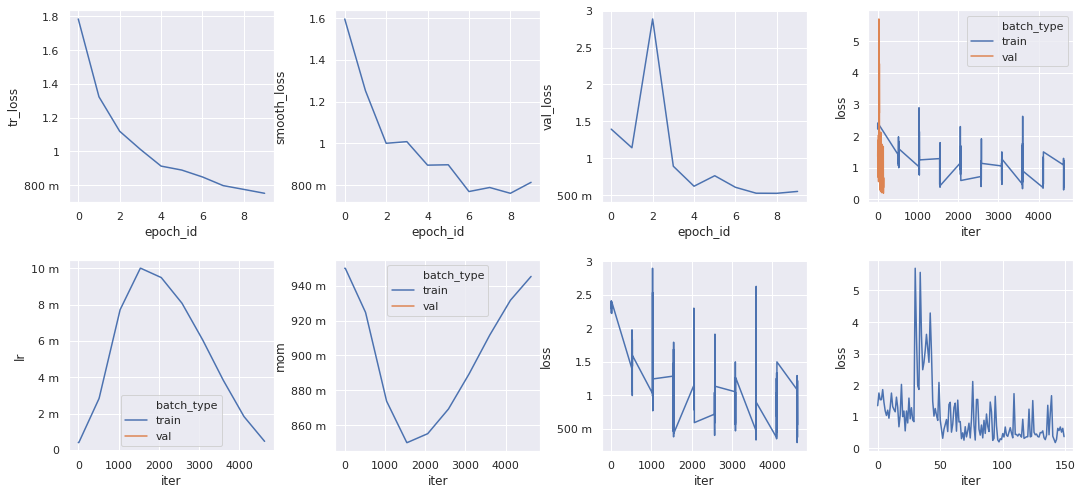

In [ ]:
loop.dtr.pd.display_metrics(is_run_df, is_batch_df, app_metrics=[])

### Run Predictions

In [ ]:
def tryit():
  db.set_trace()
  st_app.run_predict()

tryit()

#### Results

In [ ]:
epoch	tr_loss	smooth_loss	val_loss	cer	wer	time
0	3.242230	2.944051	0.000000	1.013174	1.003588	03:39
1	2.924243	2.906157	0.000000	1.000000	1.000000	03:34
2	2.901665	2.906785	0.000000	1.000000	1.000000	03:34
3	2.888298	2.890021	0.000000	0.999538	0.999951	03:34
4	2.875981	2.852535	0.000000	0.991200	1.000146	03:37
5	2.736130	2.691669	0.000000	0.858068	1.191416	04:55
6	2.647187	2.640762	0.000000	0.728977	1.244318	06:07
7	2.608828	2.616089	0.000000	0.858895	1.832292	06:42
8	2.595590	2.587646	0.000000	0.813820	1.644451	06:42
9	2.583545	2.589198	0.000000	0.807340	1.679936	06:43